## Setup Environment


In [1]:
%pip install tableone

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tableone
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from datetime import datetime
from google.colab import files
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


In [3]:
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# change this to change the right project
%env GOOGLE_CLOUD_PROJECT = dukedatathon2024

env: GOOGLE_CLOUD_PROJECT=dukedatathon2024


#### extract data to display here

In [5]:
# Construct main cohort datafrme
%%bigquery cohort_df --project dukedatathon2024

WITH total_cohort AS
(
select t2.*, t1.anchor_age, t1.gender, t1.anchor_year, t1.dod
from `physionet-data.mimiciv_icu.icustays` t2
left join `physionet-data.mimiciv_hosp.patients` t1
on t1.subject_id = t2.subject_id
),
sepsis AS
(select stay_id, subject_id, sepsis3 from `physionet-data.mimiciv_derived.sepsis3`),
limb_amp AS
(SELECT * FROM `physionet-data.mimiciv_hosp.procedures_icd` where icd_code in (
 select distinct icd_code from `physionet-data.mimiciv_hosp.d_icd_procedures`
 where lower(long_title) like '%amputation%'
 or lower(long_title) like '%debridement%'
 or lower(long_title) like '%incision%drainage%'
 or lower(long_title) like '%drainage%incision%'
 or lower(long_title) like '%necrotizing fasciitis%'
 )
)

# select count(distinct sepsis.subject_id)--total_cohort., small_cohort.
select * --total_cohort., small_cohort.
from total_cohort
inner join sepsis
on total_cohort.stay_id = sepsis.stay_id
inner join limb_amp
on total_cohort.subject_id = limb_amp.subject_id and total_cohort.hadm_id = limb_amp.hadm_id


Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
print(f'We start with {cohort_df.subject_id.unique().shape[0]} patients in our dataset.') # 625 total patients

We start with 625 patients in our dataset.


In [7]:
# cohort_df.columns

col_keep = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'anchor_age', 'gender', 'anchor_year',
       'dod', 'sepsis3', 'seq_num', 'chartdate', 'icd_code', 'icd_version']

cohort_refined = cohort_df[col_keep].copy().sort_values(by=['subject_id', 'hadm_id','intime']).reset_index(drop=True)
cohort_refined['intime'] = pd.to_datetime(cohort_refined['intime'], format='%d%b%Y:%H:%M:%S.%f')
cohort_refined['outtime'] = pd.to_datetime(cohort_refined['outtime'], format='%d%b%Y:%H:%M:%S.%f')
cohort_refined['chartdate'] = pd.to_datetime(cohort_refined['chartdate'], format='%d%b%Y:%H:%M:%S.%f')
cohort_refined['dod'] = pd.to_datetime(cohort_refined['dod'], format='%d%b%Y:%H:%M:%S.%f')
cohort_refined['within_icu_stay'] = np.where((cohort_refined['chartdate'] < (cohort_refined['outtime']+ pd.DateOffset(1))) & (cohort_refined['chartdate'] > (cohort_refined['intime']- pd.DateOffset(1))), 1, 0 )


In [8]:
cohort_refined.head(5)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,anchor_age,gender,anchor_year,dod,sepsis3,seq_num,chartdate,icd_code,icd_version,within_icu_stay
0,10003400,20214994,32128372,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2137-02-25 23:37:19,2137-03-10 21:29:36,12.911308,72,F,2134,2137-09-02,True,8,2137-03-07,8628,9,1
1,10012055,26779316,39437461,Trauma SICU (TSICU),Trauma SICU (TSICU),2148-11-19 18:15:12,2148-11-21 18:13:29,1.998808,70,M,2148,NaT,True,3,2148-11-20,8604,9,1
2,10039688,23371687,35707168,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2147-07-01 15:15:13,2147-07-02 11:18:19,0.835486,63,F,2147,NaT,True,1,2147-07-01,8622,9,1
3,10104308,27400652,33661789,Trauma SICU (TSICU),Trauma SICU (TSICU),2159-08-28 18:08:38,2159-09-11 21:39:45,14.146609,55,M,2159,NaT,True,3,2159-08-30,8622,9,1
4,10104308,27400652,33661789,Trauma SICU (TSICU),Trauma SICU (TSICU),2159-08-28 18:08:38,2159-09-11 21:39:45,14.146609,55,M,2159,NaT,True,4,2159-09-06,8622,9,1


In [9]:
cohort_refined.within_icu_stay.value_counts() # 653 procedures that happened during ICU stay

within_icu_stay
1    653
0    514
Name: count, dtype: int64

In [10]:
# filter to focus on procedures that happened during an ICU stay
cohort_pro_within_icu = cohort_refined[cohort_refined.within_icu_stay == 1]

In [11]:
print(f'Due to filtering, {len(set(cohort_pro_within_icu.subject_id))} patients are left in our study.') # left with 439 patients who had a procedure during their ICU stay

Due to filtering, 439 patients are left in our study.


In [12]:
# Modify the data structure for date difference and number calculation later
cols_within_icu = ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'anchor_age', 'gender', 'anchor_year', 'chartdate',
       'dod', 'sepsis3']
cohort_stays = cohort_pro_within_icu[cols_within_icu].drop_duplicates().copy()
cohort_stays['first_procedure'] = cohort_stays.groupby(['subject_id', 'hadm_id', 'stay_id'])['chartdate'].transform('min')
cohort_stays['last_procedure'] = cohort_stays.groupby(['subject_id', 'hadm_id', 'stay_id'])['chartdate'].transform('max')
cohort_stays['procedure_freq'] = cohort_stays.groupby(['subject_id', 'hadm_id', 'stay_id'])['chartdate'].transform('count')
cohort_final = cohort_stays.drop(['chartdate'], axis=1).drop_duplicates().reset_index(drop=True)
cohort_final.head(2)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,anchor_age,gender,anchor_year,dod,sepsis3,first_procedure,last_procedure,procedure_freq
0,10003400,20214994,32128372,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2137-02-25 23:37:19,2137-03-10 21:29:36,12.911308,72,F,2134,2137-09-02,True,2137-03-07,2137-03-07,1
1,10012055,26779316,39437461,Trauma SICU (TSICU),Trauma SICU (TSICU),2148-11-19 18:15:12,2148-11-21 18:13:29,1.998808,70,M,2148,NaT,True,2148-11-20,2148-11-20,1


In [13]:
# Preliminary calculations
## (1) frequency during an ICU stay
cohort_final['icu_stay_num'] = cohort_final.groupby(['subject_id', 'hadm_id'])['stay_id'].transform('count')
## (2) number of ICU stays during a hospotal admission
cohort_final['admission_num'] = cohort_final.groupby(['subject_id'])['hadm_id'].transform('nunique')
def calculate_day_diff(date1: str, date2: str, var_name: str):
 cohort_final[var_name] =  (cohort_final[date1] -  cohort_final[date2]).dt.days
 cohort_final[var_name] = cohort_final[var_name].apply(lambda x: max(x, 0))
## (3) the days between intime and first procedure
calculate_day_diff('first_procedure', 'intime', 'in2first_days')
## (4) the days between first procedure and discharge
calculate_day_diff('outtime', 'first_procedure', 'first2out_days')
## (5) the days between hospital admission and first procedure
calculate_day_diff('last_procedure', 'intime', 'in2last_days')
## (6) the days between last procedure and discharge
calculate_day_diff('outtime', 'last_procedure', 'last2out_days')
## (7) the days between first and last procedures
calculate_day_diff('last_procedure', 'first_procedure', 'first2last_days')
## (8) whether patients died during hospital stay (1 means yes, 0 means no)
cohort_final['death'] = np.where(cohort_final['dod'].notnull(), 1, 0)

cohort_final.head(10)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,anchor_age,gender,...,last_procedure,procedure_freq,icu_stay_num,admission_num,in2first_days,first2out_days,in2last_days,last2out_days,first2last_days,death
0,10003400,20214994,32128372,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2137-02-25 23:37:19,2137-03-10 21:29:36,12.911308,72,F,...,2137-03-07,1,1,1,9,3,9,3,0,1
1,10012055,26779316,39437461,Trauma SICU (TSICU),Trauma SICU (TSICU),2148-11-19 18:15:12,2148-11-21 18:13:29,1.998808,70,M,...,2148-11-20,1,1,1,0,1,0,1,0,0
2,10039688,23371687,35707168,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2147-07-01 15:15:13,2147-07-02 11:18:19,0.835486,63,F,...,2147-07-01,1,1,1,0,1,0,1,0,0
3,10104308,27400652,33661789,Trauma SICU (TSICU),Trauma SICU (TSICU),2159-08-28 18:08:38,2159-09-11 21:39:45,14.146609,55,M,...,2159-09-07,5,1,1,0,13,9,4,9,0
4,10160622,28904663,37309694,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2176-01-06 19:00:12,2176-01-08 16:42:33,1.904410,64,F,...,2176-01-08,1,2,1,1,0,1,0,0,1
5,10160622,28904663,36787094,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2176-01-08 16:57:23,2176-01-11 21:52:56,3.205243,64,F,...,2176-01-12,2,2,1,0,3,3,0,4,1
6,10193237,26493474,31311091,Trauma SICU (TSICU),Trauma SICU (TSICU),2112-02-06 23:24:00,2112-02-10 16:28:23,3.711377,82,M,...,2112-02-06,1,1,1,0,4,0,4,0,1
7,10251182,29312838,37030090,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2155-05-17 18:42:13,2155-05-19 16:57:53,1.927546,63,M,...,2155-05-17,1,1,1,0,2,0,2,0,1
8,10253057,22226538,36486918,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2186-12-03 20:28:00,2186-12-05 20:50:41,2.015752,61,M,...,2186-12-06,1,1,1,2,0,2,0,0,1
9,10268877,25238883,30109460,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical Intensive Care Unit (MICU),2181-02-28 22:54:04,2181-04-03 16:45:46,33.744236,64,M,...,2181-04-03,1,1,1,33,0,33,0,0,1


In [14]:
cohort_final.shape

(463, 24)

In [15]:
cohort_final.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'anchor_age', 'gender', 'anchor_year',
       'dod', 'sepsis3', 'first_procedure', 'last_procedure', 'procedure_freq',
       'icu_stay_num', 'admission_num', 'in2first_days', 'first2out_days',
       'in2last_days', 'last2out_days', 'first2last_days', 'death'],
      dtype='object')

In [16]:
# ICU admission severity markers:

# Need for mechanical ventilation within 6 hours of admission
# FiO2 > 60% within 6 hours of admission
# Need for any vasopressors (norepinephrine, epinephrine, vasopressin, dopamine, dobutamine, phenyleprine, milrinone) within 24 hours of admission
%%bigquery norepinephrine --project dukedatathon2024
select stay_id, starttime, endtime from `physionet-data.mimiciv_derived.norepinephrine`

Query is running:   0%|          |

Downloading:   0%|          |

In [17]:
%%bigquery epinephrine --project dukedatathon2024
select stay_id, starttime, endtime from `physionet-data.mimiciv_derived.epinephrine`

Query is running:   0%|          |

Downloading:   0%|          |

In [18]:
%%bigquery vasopressin --project dukedatathon2024
select stay_id, starttime, endtime from `physionet-data.mimiciv_derived.vasopressin`

Query is running:   0%|          |

Downloading:   0%|          |

In [19]:
%%bigquery dopamine --project dukedatathon2024
select stay_id, starttime, endtime from `physionet-data.mimiciv_derived.dopamine`

Query is running:   0%|          |

Downloading:   0%|          |

In [20]:
%%bigquery dobutamine --project dukedatathon2024
select stay_id, starttime, endtime from `physionet-data.mimiciv_derived.dobutamine`

Query is running:   0%|          |

Downloading:   0%|          |

In [21]:
%%bigquery phenylephrine --project dukedatathon2024
select stay_id, starttime, endtime from `physionet-data.mimiciv_derived.phenylephrine`

Query is running:   0%|          |

Downloading:   0%|          |

In [22]:
%%bigquery milrinone --project dukedatathon2024
select stay_id, starttime, endtime from `physionet-data.mimiciv_derived.milrinone`

Query is running:   0%|          |

Downloading:   0%|          |

In [23]:
%%bigquery ventilator_setting --project dukedatathon2024
select stay_id, charttime, fio2 from `physionet-data.mimiciv_derived.ventilator_setting`

Query is running:   0%|          |

Downloading:   0%|          |

In [24]:
%%bigquery ventilation_details --project dukedatathon2024
SELECT
    stay_id,
    starttime,
    endtime,
    ventilation_status
FROM
    `physionet-data.mimiciv_derived.ventilation`
WHERE
    ventilation_status = 'InvasiveVent'

Query is running:   0%|          |

Downloading:   0%|          |

In [25]:
cohort_df = cohort_final.copy()

vasopressors = pd.concat([epinephrine, vasopressin, dopamine, dobutamine, phenylephrine, milrinone])
vasopressors['starttime'] = pd.to_datetime(vasopressors['starttime'])
vasopressors['endtime'] = pd.to_datetime(vasopressors['endtime'])

cohort_df['intime'] = pd.to_datetime(cohort_df['intime'])
cohort_df['24hr_after_intime'] = cohort_df['intime'] + pd.Timedelta(days=1)

merged_df = pd.merge(cohort_df, vasopressors, on='stay_id', how='left')
merged_df['vasopressor_within_24hr'] = merged_df.apply(
    lambda row: row['starttime'] >= row['intime'] and row['starttime'] <= row['24hr_after_intime'], axis=1
)

result = merged_df.groupby('stay_id')['vasopressor_within_24hr'].any().reset_index()
result.rename(columns={'vasopressor_within_24hr': 'vasopressor_needed_within_24hr'}, inplace=True)

cohort_df = pd.merge(cohort_df, result, on='stay_id', how='left')
cohort_df['vasopressor_needed_within_24hr'] = cohort_df['vasopressor_needed_within_24hr'].fillna(False)

In [26]:
ventilation_details['starttime'] = pd.to_datetime(ventilation_details['starttime'])
cohort_df['intime'] = pd.to_datetime(cohort_df['intime'])
cohort_df['6hr_after_intime'] = cohort_df['intime'] + pd.Timedelta(hours=6)

merged_df = pd.merge(cohort_df, ventilation_details, on='stay_id', how='left')
merged_df = pd.merge(merged_df, ventilator_setting, on='stay_id', how='left')

merged_df['ventilation_within_6hr'] = merged_df.apply(
    lambda row: (row['starttime'] >= row['intime']) and
                (row['starttime'] <= row['6hr_after_intime']) and
                (row['ventilation_status'] == 'InvasiveVent'),
    axis=1
)
merged_df['fio2_above_60_within_6hr'] = merged_df.apply(
    lambda row: (row['charttime'] >= row['intime']) and
                (row['charttime'] <= row['6hr_after_intime']) and
                (row['fio2'] > 60),
    axis=1
)

result = merged_df.groupby('stay_id').agg({
    'ventilation_within_6hr': 'any',
    'fio2_above_60_within_6hr': 'any'
}).reset_index()

cohort_df = pd.merge(cohort_df, result, on='stay_id', how='left')
cohort_df['ventilation_within_6hr'] = cohort_df['ventilation_within_6hr'].fillna(False)
cohort_df['fio2_above_60_within_6hr'] = cohort_df['fio2_above_60_within_6hr'].fillna(False)

In [27]:
# ICU_admission_markers = cohort_df[['subject_id', 'stay_id', 'intime', 'outtime','vasopressor_needed_within_24hr', 'ventilation_within_6hr', 'fio2_above_60_within_6hr']].copy()
ICU_admission_markers = cohort_df.copy().drop_duplicates()

In [28]:
## Getting the peak value within 24 hours of admission
# Initial pH (continuous variable)
# Initial Lactate or lactic acid (continuous variable)
# Initial Base deficit/excess (absolute value) (continuous variable)
# Initial Creatinine (continuous variable)
# Initial Sodium (continuous variable)
# Initial Hemoglobin (Hgb) (continuous variable)
# Initial white blood cell count (WBC) (continuous variable)
# Initial C-reactive protein (continuous variable)
# Initial Glucose (continuous variable)

In [29]:
%%bigquery first_day_lab --project dukedatathon2024
SELECT stay_id, creatinine_max, sodium_max, sodium_min, hemoglobin_min, wbc_min, wbc_max FROM `physionet-data.mimiciv_derived.first_day_lab`

Query is running:   0%|          |

Downloading:   0%|          |

In [30]:
%%bigquery first_day_bg --project dukedatathon2024
SELECT stay_id, ph_max, lactate_max, baseexcess_max FROM `physionet-data.mimiciv_derived.first_day_bg`

Query is running:   0%|          |

Downloading:   0%|          |

In [31]:
%%bigquery first_day_vitals --project dukedatathon2024
SELECT stay_id, glucose_min, glucose_max FROM `physionet-data.mimiciv_derived.first_day_vitalsign`

Query is running:   0%|          |

Downloading:   0%|          |

In [32]:
# crp_values
%%bigquery crp_values --project dukedatathon2024
SELECT
    subject_id,
    charttime,
    itemid,
    valuenum
FROM
    `physionet-data.mimiciv_hosp.labevents`
WHERE
    itemid IN (50889, 51652)

Query is running:   0%|          |

Downloading:   0%|          |

In [33]:
def select_extreme_sodium(row):
    sodium_max = row['sodium_max']
    sodium_min = row['sodium_min']
    if pd.isna(sodium_max):
        return sodium_min
    if pd.isna(sodium_min):
        return sodium_max
    return sodium_max if abs(sodium_max - 140) > abs(sodium_min - 140) else sodium_min

first_day_lab['initial_sodium'] = first_day_lab.apply(select_extreme_sodium, axis=1)

def select_extreme_wbc(row):
    wbc_min = row['wbc_min']
    wbc_max = row['wbc_max']
    if pd.isna(wbc_min):
        return wbc_max
    if pd.isna(wbc_max):
        return wbc_min
    return wbc_min if 4.5 - wbc_min > wbc_max - 12 else wbc_max

first_day_lab['initial_wbc'] = first_day_lab.apply(select_extreme_wbc, axis=1)

def select_extreme_glucose(row):
    glucose_min = row['glucose_min']
    glucose_max = row['glucose_max']
    if pd.isna(glucose_min):
        return glucose_max
    if pd.isna(glucose_max):
        return glucose_min
    return glucose_min if 60 - glucose_min > glucose_max - 180 else glucose_max

first_day_vitals['initial_glucose'] = first_day_vitals.apply(select_extreme_glucose, axis=1)

In [34]:
ICU_admission_markers = ICU_admission_markers.merge(
    first_day_lab[['stay_id', 'initial_sodium', 'initial_wbc', 'creatinine_max']].rename(columns={'creatinine_max':'initial_creatinine', 'initial_sodium': 'initial_sodium', 'initial_wbc': 'initial_wbc'}),
    on='stay_id',
    how='left'
).merge(
    first_day_bg[['stay_id', 'ph_max', 'lactate_max', 'baseexcess_max']].rename(columns={
        'ph_max': 'initial_ph',
        'lactate_max': 'initial_lactate',
        'baseexcess_max': 'initial_baseexcess'
    }),
    on='stay_id',
    how='left'
).merge(
    first_day_vitals[['stay_id', 'initial_glucose']],
    on='stay_id',
    how='left'
)

# Processing CRP values
crp_values['charttime'] = pd.to_datetime(crp_values['charttime'])
ICU_admission_markers['intime'] = pd.to_datetime(ICU_admission_markers['intime'])

merged_crp = pd.merge(
    ICU_admission_markers[['subject_id', 'stay_id', 'intime']],
    crp_values,
    on='subject_id',
    how='left'
)

merged_crp['time_diff'] = (merged_crp['charttime'] - merged_crp['intime']).dt.total_seconds() / 3600
filtered_crp = merged_crp[(merged_crp['time_diff'] >= 0) & (merged_crp['time_diff'] <= 48)]
initial_crp = filtered_crp.groupby('stay_id')['valuenum'].max().reset_index().rename(columns={'valuenum': 'initial_crp'})

ICU_admission_markers = pd.merge(
    ICU_admission_markers,
    initial_crp,
    on='stay_id',
    how='left'
)


In [35]:
ICU_admission_markers

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,anchor_age,gender,...,ventilation_within_6hr,fio2_above_60_within_6hr,initial_sodium,initial_wbc,initial_creatinine,initial_ph,initial_lactate,initial_baseexcess,initial_glucose,initial_crp
0,10003400,20214994,32128372,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2137-02-25 23:37:19,2137-03-10 21:29:36,12.911308,72,F,...,False,False,138.0,3.4,1.0,7.35,11.0,-5.0,148.0,NaN
1,10012055,26779316,39437461,Trauma SICU (TSICU),Trauma SICU (TSICU),2148-11-19 18:15:12,2148-11-21 18:13:29,1.998808,70,M,...,False,False,144.0,9.7,0.7,7.47,1.2,4.0,149.0,NaN
2,10039688,23371687,35707168,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2147-07-01 15:15:13,2147-07-02 11:18:19,0.835486,63,F,...,True,False,136.0,7.1,1.8,7.47,1.3,1.0,57.0,NaN
3,10104308,27400652,33661789,Trauma SICU (TSICU),Trauma SICU (TSICU),2159-08-28 18:08:38,2159-09-11 21:39:45,14.146609,55,M,...,True,True,132.0,20.1,3.6,7.39,1.9,0.0,184.0,NaN
4,10160622,28904663,37309694,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2176-01-06 19:00:12,2176-01-08 16:42:33,1.904410,64,F,...,False,False,134.0,16.0,1.4,7.43,1.4,3.0,353.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,19970265,24514478,38356273,Trauma SICU (TSICU),Trauma SICU (TSICU),2115-03-28 18:16:00,2115-04-12 19:02:32,15.032315,20,M,...,True,True,138.0,30.2,1.1,7.40,4.5,0.0,185.0,NaN
459,19975635,26580096,35720423,Trauma SICU (TSICU),Trauma SICU (TSICU),2133-07-12 21:43:00,2133-07-17 16:29:01,4.781956,55,M,...,False,False,138.0,15.1,1.1,NaN,NaN,NaN,174.0,NaN
460,19997293,20208898,31629173,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2123-10-12 21:55:18,2123-10-18 02:05:38,5.173843,76,M,...,True,True,139.0,17.5,1.1,7.39,1.8,4.0,205.0,95.6
461,19997293,27119651,35326307,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2123-11-02 00:42:00,2123-11-02 17:26:48,0.697778,76,M,...,False,False,139.0,9.4,2.1,7.47,2.2,13.0,134.0,NaN


In [36]:
# Last markers prior to or day of floor transfer/ICU discharge:

# On mechanical ventilation (yes/no)
# FiO2 > 60% (yes/no)
# On any vasopressors (norepinephrine, epinephrine, vasopressin, dopamine, dobutamine, phenylephrine, milrinone) (yes/no)

In [37]:
ICU_markers = ICU_admission_markers.copy()

# Rename columns to indicate initial measurements
ICU_markers.rename(columns={
    'ventilation_within_6hr': 'initial_ventilation_within_6hr',
    'fio2_above_60_within_6hr': 'initial_fio2_above_60_within_6hr',
    'vasopressor_needed_within_24hr': 'initial_vasopressor_needed_within_24hr'
}, inplace=True)

In [38]:

vasopressors['endtime'] = pd.to_datetime(vasopressors['endtime'])
vasopressors['starttime'] = pd.to_datetime(vasopressors['starttime'])
ventilator_setting['charttime'] = pd.to_datetime(ventilator_setting['charttime'])
ventilation_details['endtime'] = pd.to_datetime(ventilation_details['endtime'])
ICU_markers['outtime'] = pd.to_datetime(ICU_markers['outtime'])

filtered_vasopressors = pd.merge(
    ICU_markers[['stay_id', 'outtime']],
    vasopressors,
    on='stay_id',
    how='left'
)

filtered_vasopressors = filtered_vasopressors[filtered_vasopressors['starttime'] < filtered_vasopressors['outtime']]

# Find the maximum endtime for each stay_id where the above condition is true
max_endtime = filtered_vasopressors.groupby('stay_id')['endtime'].max().reset_index().rename(columns={'endtime': 'endtime_last_vasopressor'})

# Merge the results back to ICU_markers
ICU_markers = pd.merge(
    ICU_markers,
    max_endtime,
    on='stay_id',
    how='left'
)

last_fio2 = ventilator_setting.sort_values(by='charttime').drop_duplicates(subset='stay_id', keep='last')
last_fio2.rename(columns={'charttime': 'last_fio2_charttime', 'fio2': 'last_fio2'}, inplace=True)
ICU_markers = pd.merge(
    ICU_markers,
    last_fio2[['stay_id', 'last_fio2_charttime', 'last_fio2']],
    on='stay_id',
    how='left'
)

ICU_markers = pd.merge(
    ICU_markers,
    ventilation_details.groupby('stay_id')['endtime'].max().reset_index().rename(columns={'endtime': 'endtime_last_ventilation'}),
    on='stay_id',
    how='left'
)

In [39]:
ICU_markers['off_vasopressors'] = (~ICU_markers['endtime_last_vasopressor'].notna()) | (ICU_markers['endtime_last_vasopressor'] <= ICU_markers['outtime'])
ICU_markers['last_fio2_above_60'] = (ICU_markers['last_fio2_charttime'].notna()) & ((ICU_markers['last_fio2_charttime'] <= ICU_markers['outtime']) & (ICU_markers['last_fio2'] > 60))
ICU_markers['off_ventilation'] = (~ICU_markers['endtime_last_ventilation'].notna()) | (ICU_markers['endtime_last_ventilation'] <= ICU_markers['outtime'])


In [40]:
# pH
# Lactate or lactic acid
# Base deficit/excess (absolute value)
# Creatinine
# Sodium
# Hemoglobin (Hgb)
# White blood cell count (WBC)
# C-reactive protein
# Glucose

In [41]:
%%bigquery bg_data --project dukedatathon2024
SELECT
    subject_id,
    charttime,
    ph,
    lactate,
    baseexcess,
    hemoglobin
FROM
    `physionet-data.mimiciv_derived.bg`

Query is running:   0%|          |

Downloading:   0%|          |

In [42]:
%%bigquery chemistry_data --project dukedatathon2024
SELECT
    subject_id,
    charttime,
    creatinine,
    sodium,
    glucose
FROM
    `physionet-data.mimiciv_derived.chemistry`

Query is running:   0%|          |

Downloading:   0%|          |

In [43]:
%%bigquery cbc_data --project dukedatathon2024
SELECT
    subject_id,
    charttime,
    wbc
FROM
    `physionet-data.mimiciv_derived.complete_blood_count`

Query is running:   0%|          |

Downloading:   0%|          |

In [44]:
def fetch_last_lab_results(icu_df, lab_df, lab_columns):

    lab_df['charttime'] = pd.to_datetime(lab_df['charttime'])
    icu_df['intime'] = pd.to_datetime(icu_df['intime'])
    icu_df['outtime'] = pd.to_datetime(icu_df['outtime'])

    merged = pd.merge(icu_df[['subject_id', 'stay_id', 'intime', 'outtime']], lab_df, on='subject_id', how='left')
    valid_results = merged[(merged['charttime'] >= merged['intime']) & (merged['charttime'] <= merged['outtime'])]

    for column in lab_columns:
        if column in lab_df.columns:
            # Sorting by charttime to get the last result before outtime
            last_values = valid_results.sort_values(by='charttime').groupby('stay_id').last()[[column]]
            last_values.rename(columns={column: f'last_{column}'}, inplace=True)
            icu_df = pd.merge(icu_df, last_values, on='stay_id', how='left')

    return icu_df

ICU_markers = fetch_last_lab_results(ICU_markers, bg_data, ['ph', 'lactate', 'baseexcess', 'hemoglobin'])
ICU_markers = fetch_last_lab_results(ICU_markers, chemistry_data, ['creatinine', 'sodium', 'glucose'])
ICU_markers = fetch_last_lab_results(ICU_markers, cbc_data, ['wbc'])
ICU_markers = fetch_last_lab_results(ICU_markers, crp_values, ['valuenum'])

In [45]:
ICU_markers.rename(columns={'last_valuenum': 'last_crp'}, inplace=True)

In [46]:
complete_df = ICU_markers.copy()

def check_floor_readiness(row):
    conditions_met = [
        row['last_ph'] >= 7.3 if pd.notna(row['last_ph']) else True,
        row['last_lactate'] <= 3 if pd.notna(row['last_lactate']) else True,
        abs(row['last_baseexcess']) <= 3 if pd.notna(row['last_baseexcess']) else True,
        (row['last_creatinine'] <= 1.6 or row['last_creatinine'] < 1.5 * row['initial_creatinine']) if pd.notna(row['last_creatinine']) and pd.notna(row['initial_creatinine']) else True,
        row['off_ventilation'] == True and (row['last_fio2_above_60'] == False),
        row['off_vasopressors'] == True,
        135 <= row['last_sodium'] <= 145 if pd.notna(row['last_sodium']) else True,
        row['last_hemoglobin'] >= 7.0 if pd.notna(row['last_hemoglobin']) else True,
        4.5 <= row['last_wbc'] <= 12 if pd.notna(row['last_wbc']) else True,
        row['last_crp'] <= 20 if pd.notna(row['last_crp']) else True,
        60 <= row['last_glucose'] <= 180 if pd.notna(row['last_glucose']) else True
    ]
    return all(conditions_met)

complete_df['readiness'] = complete_df.apply(check_floor_readiness, axis=1)


In [47]:
complete_df = complete_df.drop(columns=['endtime_last_vasopressor', 'last_fio2_charttime',
       'last_fio2', 'endtime_last_ventilation', '6hr_after_intime', '24hr_after_intime']).copy()

In [70]:
table1 = complete_df[['subject_id', 'hadm_id', 'stay_id', 'anchor_age', 'gender', 'in2first_days', 'last2out_days', 'first2last_days', 'death','procedure_freq', 'readiness']].drop_duplicates()
table1.shape

(463, 11)

In [80]:
for i in ['anchor_age','in2first_days', 'last2out_days', 'first2last_days', 'procedure_freq']:
  print(f'''{i}: {table1[i].median()}''')
# table1.anchor_age.median()

anchor_age: 61.0
in2first_days: 0.0
last2out_days: 2.0
first2last_days: 0.0
procedure_freq: 1.0


In [78]:
for i in ['gender','death','readiness']:
  print(f'''{"#"*50}
        {complete_df[i].value_counts(normalize=True)}'''
        )

##################################################
        gender
1.0    0.647948
0.0    0.352052
Name: proportion, dtype: float64
##################################################
        death
0.0    0.591793
1.0    0.408207
Name: proportion, dtype: float64
##################################################
        readiness
0    0.779698
1    0.220302
Name: proportion, dtype: float64


gender
1.0    0.647948
0.0    0.352052
Name: proportion, dtype: float64

In [72]:
complete_df['death'].value_counts(normalize=True)

death
0.0    0.591793
1.0    0.408207
Name: proportion, dtype: float64

In [73]:
complete_df['readiness'].value_counts(normalize=True)

readiness
0    0.779698
1    0.220302
Name: proportion, dtype: float64

In [49]:
# prompt: download complete_df

complete_df.to_csv('complete_df.csv', index=False)
files.download('complete_df.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
# Replace 'M' with 1 and 'F' with 0 in the 'gender' column
complete_df['gender'] = complete_df['gender'].replace({'M': 1, 'F': 0})complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 48 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   subject_id                              463 non-null    Int64         
 1   hadm_id                                 463 non-null    Int64         
 2   stay_id                                 463 non-null    Int64         
 3   first_careunit                          463 non-null    object        
 4   last_careunit                           463 non-null    object        
 5   intime                                  463 non-null    datetime64[us]
 6   outtime                                 463 non-null    datetime64[us]
 7   los                                     463 non-null    float64       
 8   anchor_age                              463 non-null    Int64         
 9   gender                                  463 non-null  

In [52]:
# Replace 'M' with 1 and 'F' with 0 in the 'gender' column
complete_df['gender'] = complete_df['gender'].replace({'M': 1, 'F': 0})

# Specify columns to convert to float
X_cols = ['anchor_age', 'gender', 'anchor_year',
       'sepsis3', 'procedure_freq',
       'icu_stay_num', 'admission_num', 'in2first_days', 'first2out_days',
       'in2last_days', 'last2out_days', 'first2last_days', 'death',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose',
       'initial_crp', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness']

int_cols = ['anchor_age' ,'gender','anchor_year','procedure_freq','icu_stay_num','admission_num','in2first_days','first2out_days','in2last_days','last2out_days','first2last_days','death']
bol_col = ['sepsis3','initial_vasopressor_needed_within_24hr','initial_ventilation_within_6hr','initial_fio2_above_60_within_6hr','off_vasopressors','last_fio2_above_60','off_ventilation','readiness']

# Convert specified columns to float using astype()
complete_df[int_cols] = complete_df[int_cols].astype(float)
complete_df[bol_col] = complete_df[bol_col].astype(int)
complete_df = complete_df.fillna(np.nan)


In [53]:
# check for variable correlation & feature selection
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable
y_vif, X_vif = dmatrices('los ~ anchor_age+gender+anchor_year+sepsis3+procedure_freq+icu_stay_num+admission_num+in2first_days+first2out_days+in2last_days+last2out_days+first2last_days+death+initial_vasopressor_needed_within_24hr+initial_ventilation_within_6hr+initial_fio2_above_60_within_6hr+initial_sodium+initial_wbc+initial_creatinine+initial_ph+initial_lactate+initial_baseexcess+initial_glucose+initial_crp+off_vasopressors+last_fio2_above_60+off_ventilation+last_ph+last_lactate+last_baseexcess+last_hemoglobin+last_creatinine+last_sodium+last_glucose+last_wbc+last_crp+readiness', data=complete_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['variable'] = X_vif.columns

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [54]:
# Filter the DataFrame to get variable names with VIF less than 5
selected_variables = vif.loc[vif['VIF'].fillna(0) < 5, 'variable'].tolist()
selected_variables.remove('Intercept')

In [55]:
# split train & test
X = complete_df[selected_variables].fillna(0)
y = complete_df['los']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

#################### Prediction Outcome on Test Data ####################
Mean Squared Error (MSE): 75.4636
R-squared (R2): 0.1787
#################### Feature Importance Summary ####################
sepsis3: 0.00000
procedure_freq: -1.06534
icu_stay_num: -0.02533
admission_num: 0.94038
first2last_days: 2.59312
death: 0.54007
initial_ventilation_within_6hr: 1.47623
initial_creatinine: 1.06036
off_vasopressors: 0.00000
last_fio2_above_60: 0.44346
off_ventilation: -0.00000
last_sodium: 0.83740
readiness: -0.79981


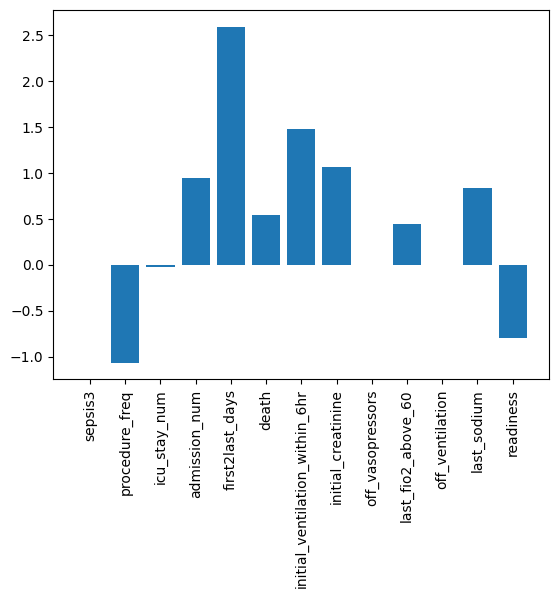

In [83]:
# normalize & perform linear regression & print regression output
# Initialize StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, r2_score

scaler = StandardScaler()

# Fit and transform the scaler on x_train
X_train_scaled = scaler.fit_transform(X_train)

# Transform X_test using the same scaler
X_test_scaled = scaler.transform(X_test)

# fit linear model
model = LinearRegression()

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'''{'#'*20} Prediction Outcome on Test Data {'#'*20}''')
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# summarize feature importance
print(f'''{'#'*20} Feature Importance Summary {'#'*20}''')
importance = model.coef_
for i,v in enumerate(importance):
  print(f'{X_train.columns[i]}: {v:.5f}')
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xticks(np.arange(0, len(X_train.columns), step=1), labels = X_train.columns, rotation=90)
pyplot.show()


In [ ]:
# get feature importance

In [ ]:
# Outcomes:
# Primary outcomes
# Secondary outcomes

In [ ]:
# # prompt: download the complete_df to local

# complete_df.to_csv('complete_df.csv')
# files.download('complete_df.csv')
